https://discourse.pymc.io/t/data-aggregation-in-crowdsensing-application/1072/18

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.distributions import Interpolated
from scipy import stats


def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
# Initialize random number generator
np.random.seed(123)

# Target values
t = [38.095, 13.346, 30.106, 13.353]

# Users' precision in term of sigma
s = [0.01, 0.05, 0.03, 0.12]

# Number of measures for each target
n_measures = 10

# Simulate some data
measures = []
for i in range(0, 4):
    y1 = t[i] + np.random.randn(n_measures) * s[0]
    y2 = t[i] + np.random.randn(n_measures) * s[1]
    y3 = t[i] + np.random.randn(n_measures) * s[2]
    y4 = t[i] + np.random.randn(n_measures) * s[3]
    x = np.array([y1, y2, y3, y4])
    measures.append(x)

In [18]:
with pm.Model() as hierachical_model:
    # Latent mean and sigma, I want to estimate these parameters
    mu = pm.Normal('mu', 0., 100.)
    rho = pm.HalfNormal('rho', 10.)

    sigma1 = pm.HalfNormal('sigma1', rho)
    sigma2 = pm.HalfNormal('sigma2', rho)
    sigma3 = pm.HalfNormal('sigma3', rho)
    sigma4 = pm.HalfNormal('sigma4', rho)

    like1 = pm.Normal('like1', mu, sigma1, observed=measures[0][0])
    like2 = pm.Normal('like2', mu, sigma2, observed=measures[0][1])
    like3 = pm.Normal('like3', mu, sigma3, observed=measures[0][2])
    like4 = pm.Normal('like4', mu, sigma4, observed=measures[0][3])

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma4_log__, sigma3_log__, sigma2_log__, sigma1_log__, rho_log__, mu]
100%|██████████| 1500/1500 [00:23<00:00, 64.08it/s] 
The acceptance probability does not match the target. It is 0.9522403790083452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9583093119784403, but should be close to 0.8. Try to increase the number of tuning steps.


In [19]:
for j in range(1,4):

    with pm.Model() as model:
        # Latent mean and sigma, I want to estimate these parameters
        mu = pm.Normal('mu', 0., 100.)

        # Priors are posteriors from previous iteration
        sigma1 = from_posterior('sigma1', trace['sigma1'])
        sigma2 = from_posterior('sigma2', trace['sigma2'])
        sigma3 = from_posterior('sigma3', trace['sigma3'])
        sigma4 = from_posterior('sigma4', trace['sigma4'])
    
        like1 = pm.Normal('like1', mu, sigma1, observed=measures[j][0])
        like2 = pm.Normal('like2', mu, sigma2, observed=measures[j][1])
        like3 = pm.Normal('like3', mu, sigma3, observed=measures[j][2])
        like4 = pm.Normal('like4', mu, sigma4, observed=measures[j][3])
        
        trace = pm.sample(1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma4_interval__, sigma3_interval__, sigma2_interval__, sigma1_interval__, mu]
100%|██████████| 1500/1500 [01:18<00:00, 27.55it/s]
The acceptance probability does not match the target. It is 0.9779216336696305, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9844412091908469, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma4_interval__, sigma3_interval__, sigma2_interval__, sigma1_interval__, mu]
100%|██████████| 1500/1500 [04:07<00:00,  2.73it/s]
The acceptance probability does not match the target. It is 0.9997121841109345, but should be close to 0.8. Try

https://discourse.pymc.io/t/performance-speedup-for-updating-posterior-with-new-data/1097

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from io import BytesIO
import pymc3 as pm
from pymc3.distributions import Interpolated
import theano
from scipy import stats

In [19]:
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12, nrows * 1.4),
                      lines={k: v['mean'] for k, v in
                             pm.df_summary(trcs, varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.df_summary(trcs, varnames=varnames)['mean']):
        ax[i, 0].annotate('{:.2f}'.format(mn), xy=(mn, 0), xycoords='data',
                          xytext=(5, 10), textcoords='offset points', rotation=90,
                          va='bottom', fontsize='large', color='#AA0022')


def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log', rv.name) or re.search('_interval', rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


def generate_data():
    intercept = 2
    x1 = np.random.random_sample(1)[0]
    true_coeff = -2
    theta = np.exp(intercept + true_coeff * x1)
    output = np.random.poisson(theta)

    return {'intercept': intercept, 'x1': x1, 'true_coeff': true_coeff, 'output': output, 'theta': theta}


train = pd.DataFrame(data=[generate_data() for _ in range(100)], columns=generate_data().keys())

output_shared = theano.shared(train['output'].values)
x1_shared = theano.shared(train['x1'].values)

In [20]:
with pm.Model() as model:
    alpha_0 = pm.Normal('alpha_0', mu=0, sd=10)
    alpha_1 = pm.Normal('alpha_1', mu=-1, sd=0.5)
    theta = (alpha_0 + alpha_1 * x1_shared)

    likelihood = pm.Poisson(
        'output',
        mu=np.exp(theta),
        observed=output_shared,
    )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_0]
100%|██████████| 1500/1500 [00:01<00:00, 1286.39it/s]


In [21]:
traces = [trace]

In [17]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [18]:
for _ in range(10):
    new_data = pd.DataFrame(data=[generate_data() for _ in range(1)], columns=generate_data().keys())
    output_shared = theano.shared(new_data['output'].values)
    x1_shared = theano.shared(new_data['x1'].values)

    model = pm.Model()
    with model:
        # pm.glm.GLM.from_formula(formula=fml, data=new_data, family=pm.glm.families.NegativeBinomial())
        alpha_0 = from_posterior('alpha_0', trace['alpha_0'])
        alpha_1 = from_posterior('alpha_1', trace['alpha_1'])
        theta = (alpha_0 + alpha_1 * x1_shared)

        likelihood = pm.Poisson('output',
                                mu=np.exp(theta),
                                observed=output_shared
                                )
        trace = pm.sample(1000, init='adapt_diag', chains=2, cores=4, progressbar=False)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha_1_interval__, alpha_0_interval__]
The acceptance probability does not match the target. It is 0.68919193017805, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha_1_interval__, alpha_0_interval__]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.12238926356673838, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha_1_interval__, a

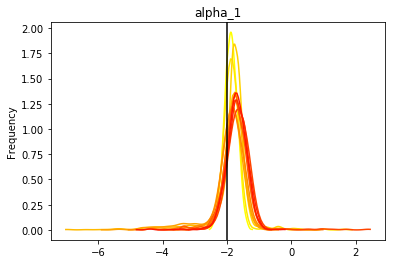

In [19]:
cmap = mpl.cm.autumn

for param in ['alpha_1']:
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'alpha_1': -2}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()

In [33]:
import theano.tensor as tt

In [40]:
def from_posterior2(samples):
    smin, smax = samples.min(), samples.max()
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return x, y

In [41]:
new_data = pd.DataFrame(data=[generate_data() for _ in range(1)], columns=generate_data().keys())
output_shared = theano.shared(new_data['output'].values)
x1_shared = theano.shared(new_data['x1'].values)
x0_, pdf0_ = from_posterior2(trace['alpha_0'])
x0 = theano.shared(x0_)
pdf0 = theano.shared(pdf0_)
x1_, pdf1_ = from_posterior2(trace['alpha_1'])
x1 = theano.shared(x1_)
pdf1 = theano.shared(pdf1_)

with pm.Model() as update_model:
    # pm.glm.GLM.from_formula(formula=fml, data=new_data, family=pm.glm.families.NegativeBinomial())
    alpha_0 = Interpolated('alpha_0', x0, pdf0)
    alpha_1 = Interpolated('alpha_1', x1, pdf1)
    theta = (alpha_0 + alpha_1 * x1_shared)

    likelihood = pm.Poisson('output',
                            mu=np.exp(theta),
                            observed=output_shared
                            )
    trace = pm.sample(1000, init='adapt_diag', chains=2, cores=4, progressbar=False)
    
for _ in range(1, 10):
    new_data = pd.DataFrame(data=[generate_data() for _ in range(1)], columns=generate_data().keys())
    output_shared.set_value(new_data['output'].values)
    x1_shared.set_value(new_data['x1'].values)
    x0_, pdf0_ = from_posterior2(trace['alpha_0'])
    x0.set_value(x0_)
    pdf0.set_value(pdf0_)
    x1_, pdf1_ = from_posterior2(trace['alpha_1'])
    x1.set_value(x1_)
    pdf1.set_value(pdf1_)
    
    with update_model:
        trace = pm.sample(1000, init='adapt_diag', chains=2, cores=4, progressbar=False)
        traces.append(trace)

AxisError: axis -1 is out of bounds for array of dimension 0

In [22]:
new_data = pd.DataFrame(data=[generate_data() for _ in range(1)], columns=generate_data().keys())
output_shared = theano.shared(new_data['output'].values)
x1_shared = theano.shared(new_data['x1'].values)
    
mu0 = theano.shared(trace['alpha_0'].mean(), name='hyper_mu0')
sd0 = theano.shared(trace['alpha_0'].std(), name='hyper_sd0')
mu1 = theano.shared(trace['alpha_1'].mean(), name='hyper_mu1')
sd1 = theano.shared(trace['alpha_1'].std(), name='hyper_sd1')

with pm.Model() as update_model:
    alpha_0 = pm.StudentT('alpha_0', mu=mu0, sd=sd0, nu=1, testval=0.)
    alpha_1 = pm.StudentT('alpha_1', mu=mu1, sd=sd1, nu=1, testval=0.)
    theta = (alpha_0 + alpha_1 * x1_shared)

    likelihood = pm.Poisson(
        'output',
        mu=np.exp(theta),
        observed=output_shared,
    )
    trace = pm.sample(1000)
    traces.append(trace)
    
for _ in range(1, 10):
    new_data = pd.DataFrame(data=[generate_data() for _ in range(1)], columns=generate_data().keys())
    output_shared.set_value(new_data['output'].values)
    x1_shared.set_value(new_data['x1'].values)
    mu0.set_value(trace['alpha_0'].mean())
    sd0.set_value(trace['alpha_0'].std())
    mu1.set_value(trace['alpha_1'].mean())
    sd1.set_value(trace['alpha_1'].std())
    
    with update_model:
        trace = pm.sample(1000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_0]
100%|██████████| 1500/1500 [00:00<00:00, 1738.67it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_0]
100%|██████████| 1500/1500 [00:00<00:00, 1944.65it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_0]
100%|██████████| 1500/1500 [00:00<00:00, 1700.11it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_0]
100%|██████████| 1500/1500 [00:00<00:00, 1860.10it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_0]
100%|██████████| 1500/1500 [00:00<00:00, 1814.13it/s]
Auto-assig

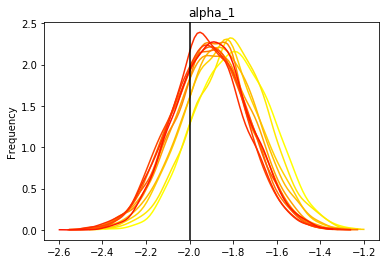

In [24]:
cmap = mpl.cm.autumn

for param in ['alpha_1']:
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'alpha_1': -2}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()